In [55]:
from feature_utils.parallel import get_optimal_radial_basis_hypers_parallel, get_features_in_parallel
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
from rascal.representations import SphericalInvariants as SOAP
from skcosmo.model_selection import atom_groups_by_frame
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from loader.loader import load_data
from copy import deepcopy
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import json
import joblib

In [59]:
feature_dict = {1:[
 2.0,
 4.5,
 0.3,
 3.,
 1.]
,6:[
 2.601,
 4.643,
 0.179,
 4.698,
 1.968]
                ,7:[
 2.0,
 4.5,
 0.3,
 3.,
 1.],8:[2.415,
 5.63,
 0.176,
 6.829,
 3.30]}

In [60]:
def update_hypers(hypers,param_list,params):
        cutoff_dict = hypers["cutoff_function_parameters"]
        for param,value in zip(param_list, params):
                if param in cutoff_dict:
                        hypers["cutoff_function_parameters"][param] = value
                else:
                        hypers[param] = value
        return hypers

In [66]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=4.5,
              max_radial=8,
              max_angular=8,
              gaussian_sigma_constant=0.3,
              gaussian_sigma_type="Constant",
              radial_basis="GTO",
              normalize=True,
              cutoff_smooth_width=0.3,
              cutoff_function_type="RadialScaling",
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              cutoff_function_parameters= dict(rate=1.,
                    scale= 2.0,
                    exponent=3.
                        ),
              compute_gradients=False,
              expansion_by_species_method="user defined",
              global_species=[1, 6, 7, 8, 16]
              )


errors = {1:None,6:None,7:None,8:None}

for specie in [6,8]:
    train_structures, test_structures, train_properties, test_properties = load_data("../make_tensor_data/train_tensor/CSD-3k+S546_shift_tensors.xyz",\
                                                                                    "../make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz",selected_species=specie)
    species_alphas = []
    specie_train_rmse = []
    specie_test_rmse = []
    specie_train_mae = []
    specie_test_mae = []
    atom_groups = atom_groups_by_frame(train_structures)
    numbers_of_feats = []
    
    for num in range(8,9):
        
        int_hyp = hypers.copy()
        int_hyp = update_hypers(int_hyp,[
         'scale',
         'interaction_cutoff',
         'gaussian_sigma_constant',
         'exponent',
         'rate'],feature_dict[specie])
        
        int_hyp["max_radial"]  = num
        int_hyp["max_angular"] = num
        
        int_hyp = get_optimal_radial_basis_hypers_parallel(int_hyp,train_structures,expanded_max_radial=20)
        
        Xtrain = get_features_in_parallel(train_structures,calculator=SOAP,hypers=int_hyp)
        Xtest = get_features_in_parallel(test_structures,calculator=SOAP,hypers=int_hyp)
        
        clf = GridSearchCV(Ridge(),param_grid={"alpha":np.logspace(-6,3,10)},cv=GroupKFold(n_splits=5),scoring="neg_mean_squared_error")
        #.split(Xtrain,train_properties,groups=atom_groups)
        
        clf.fit(Xtrain,train_properties,groups=atom_groups) 
        species_alphas.append(clf.cv_results_['params'][clf.best_index_]["alpha"])
        
        Y_test_pred = clf.predict(Xtest)
        Y_train_pred = clf.predict(Xtrain)
        
        num_feat = Xtrain.shape[1]
        rmse_test = mean_squared_error(test_properties,Y_test_pred,squared=False)
        print("{} RMSE: {}".format(specie,rmse_test))
        rmse_train = mean_squared_error(train_properties,Y_train_pred,squared=False)
        mae_test = mean_absolute_error(test_properties,Y_test_pred)
        mae_train = mean_absolute_error(train_properties,Y_train_pred)
        specie_train_rmse.append(rmse_train)
        specie_test_rmse.append(rmse_test)
        specie_train_mae.append(mae_train)
        specie_test_mae.append(mae_test)
        numbers_of_feats.append(num_feat)
        
        with open("{}_hypers.json".format(specie), 'w') as fileob:
            json.dump(int_hyp, fileob) 
            
        joblib.dump(clf.best_estimator_,"{}_RR.joblib".format(specie))
    error_dict = {"rmse_test":specie_test_rmse,"rmse_train":specie_train_rmse,"mae_test":specie_test_mae,"mae_train":specie_train_mae,"alphas":species_alphas,"num_feats":numbers_of_feats}
    errors[specie] = error_dict



6 RMSE: 4.469394898366364
8 RMSE: 17.388590457079964


In [65]:
clf.best_estimator_

Ridge(alpha=0.001)

In [68]:
for specie in [1,6,7,8]:
    train_structures, test_structures, train_properties, test_properties = load_data("../make_tensor_data/train_tensor/CSD-3k+S546_shift_tensors.xyz",\
                                                                                    "../make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz",random_subsample_train=1,selected_species=specie)
    fh = open("../data/RR_this_work_models/hypers/{}_hypers.json".format(specie))
    hypers = json.load(fh)
    fh.close()
    model = joblib.load("../data/RR_this_work_models/{}_RR.joblib".format(specie))
    Xtest = get_features_in_parallel(test_structures,calculator=SOAP,hypers=hypers)
    Ypred = model.predict(Xtest)
    
    print("{} rmse is: {}".format(specie,mean_squared_error(test_properties,Ypred,squared=False)))
    print("{} mae is: {}".format(specie,mean_absolute_error(test_properties,Ypred)))
    

1 rmse is: 0.48325284445724115
1 mae is: 0.36722468687427745
6 rmse is: 4.469394898366364
6 mae is: 3.2252157189399235
7 rmse is: 14.255481416210506
7 mae is: 9.339624793665356
8 rmse is: 17.388590457079964
8 mae is: 12.535261354599577


In [70]:
errors[8]

{'rmse_test': [17.388590457079964],
 'rmse_train': [12.376145407782753],
 'mae_test': [12.535261354599577],
 'mae_train': [8.92352600221422],
 'alphas': [0.001],
 'num_feats': [8640]}

In [12]:
fb = open("errors_RR_mine.json")
fg = open("errors_RR_Engel.json")
myerrors = json.load(fb)
engelerrors = json.load(fg)
fb.close()
fg.close()

In [3]:
from matplotlib import pyplot as plt

In [6]:
errors

{'1': {'rmse_test': [0.691578357492086,
   0.6077552433678699,
   0.5485716419785444,
   0.5153465494743699,
   0.49474621659625184,
   0.4791648163693447,
   0.4714706373328724,
   0.46878407161426033],
  'rmse_train': [0.7233393436142814,
   0.6164010254753329,
   0.5399758404514986,
   0.4876038386836535,
   0.44823234387145566,
   0.4162713634993144,
   0.3929555939897808,
   0.3735408556913614],
  'mae_test': [0.5327737103573152,
   0.46430421924790505,
   0.41815931946666907,
   0.3924084466034395,
   0.3752698196711288,
   0.3635112010742791,
   0.3573244508161443,
   0.3558303979332653],
  'mae_train': [0.5393357647434766,
   0.462691346209443,
   0.4077684353891909,
   0.3699492587952866,
   0.34094349145058767,
   0.31679967097450873,
   0.29920316760172744,
   0.2839768345611915],
  'alphas': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
  'num_feats': [540, 1200, 2250, 3780, 5880, 8640, 12150, 16500]},
 '6': {'rmse_test': [6.239285157317348,
   5.483117863048458

In [10]:
errors["1"]

{'rmse_test': [0.691578357492086,
  0.6077552433678699,
  0.5485716419785444,
  0.5153465494743699,
  0.49474621659625184,
  0.4791648163693447,
  0.4714706373328724,
  0.46878407161426033],
 'rmse_train': [0.7233393436142814,
  0.6164010254753329,
  0.5399758404514986,
  0.4876038386836535,
  0.44823234387145566,
  0.4162713634993144,
  0.3929555939897808,
  0.3735408556913614],
 'mae_test': [0.5327737103573152,
  0.46430421924790505,
  0.41815931946666907,
  0.3924084466034395,
  0.3752698196711288,
  0.3635112010742791,
  0.3573244508161443,
  0.3558303979332653],
 'mae_train': [0.5393357647434766,
  0.462691346209443,
  0.4077684353891909,
  0.3699492587952866,
  0.34094349145058767,
  0.31679967097450873,
  0.29920316760172744,
  0.2839768345611915],
 'alphas': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
 'num_feats': [540, 1200, 2250, 3780, 5880, 8640, 12150, 16500]}

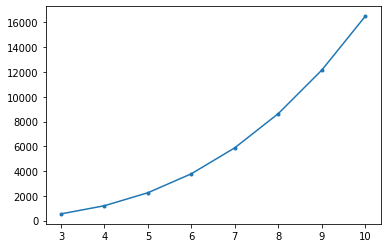

In [28]:
grid = [*range(3,11)]
plt.plot(grid,myerrors["1"]["num_feats"],label="num_feats",marker="o",markersize=3)

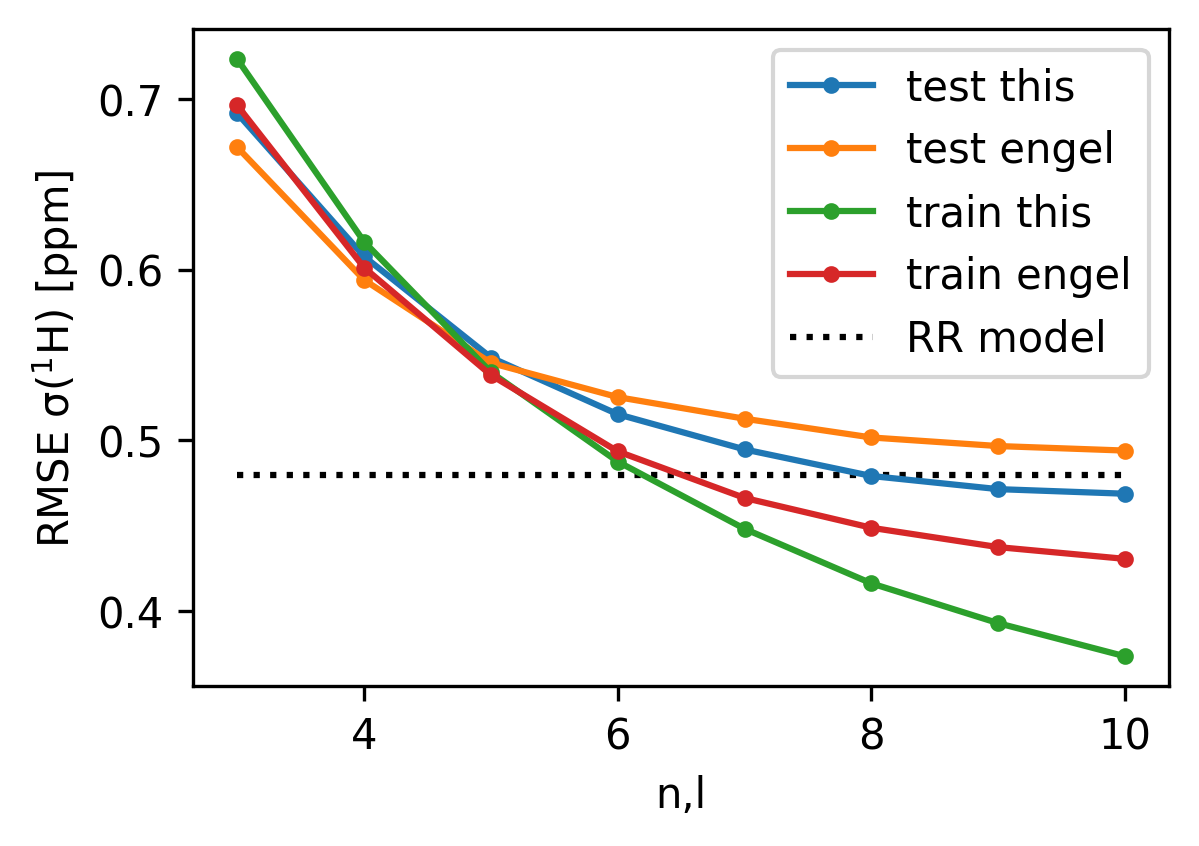

In [80]:
grid = [*range(3,11)]
plt.figure(figsize=(4.2,2.9),dpi=300)
plt.plot(grid,myerrors["1"]["rmse_test"],label="test this",marker="o",markersize=3)
plt.plot(grid,engelerrors["1"]["rmse_test"],label="test engel",marker="o",markersize=3)
plt.plot(grid,myerrors["1"]["rmse_train"],label="train this",marker="o",markersize=3)
plt.plot(grid,engelerrors["1"]["rmse_train"],label="train engel",marker="o",markersize=3)

plt.hlines(0.48,3,10,color="black",linestyle="dotted",label="RR model")
plt.legend()
plt.xlabel("n,l")
plt.ylabel("RMSE σ($^{1}$H) [ppm]")
plt.savefig("n_l_curve_H.png",dpi=300,bbox_inches='tight')

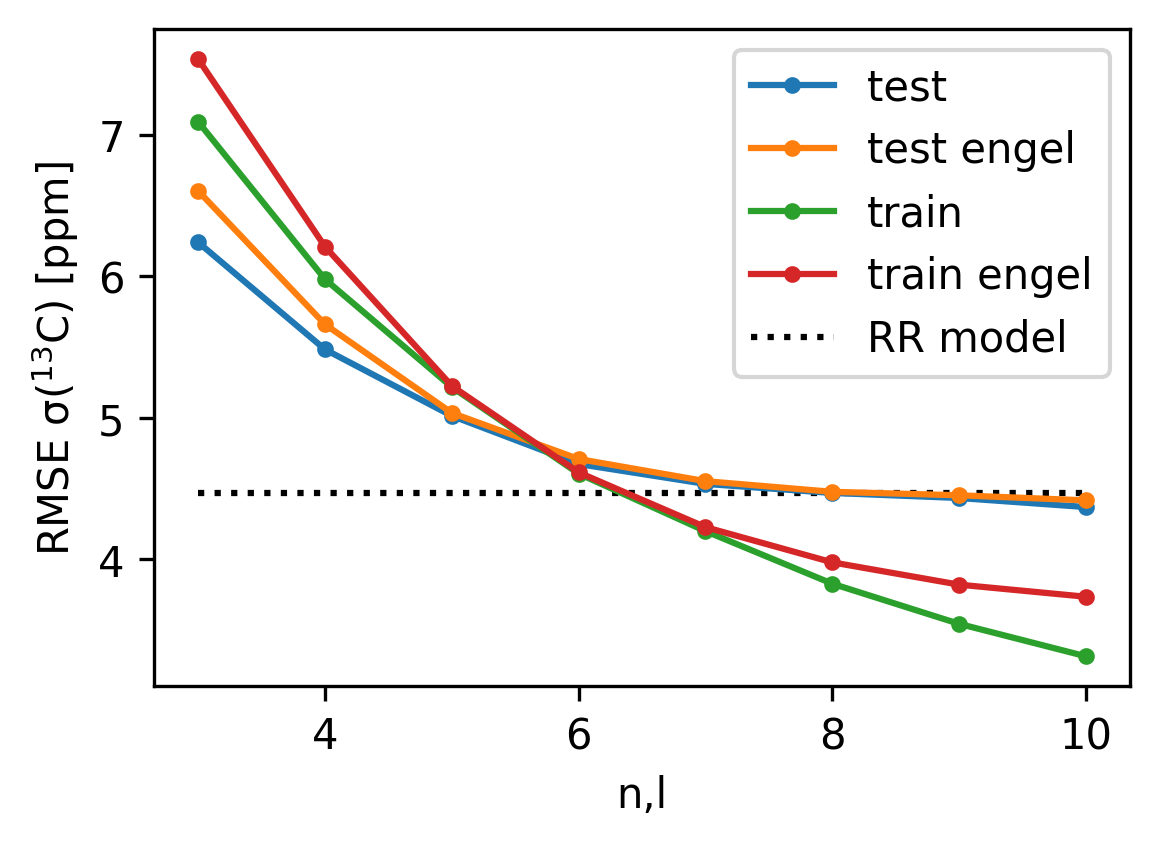

In [76]:
plt.figure(figsize=(4.2,2.9),dpi=300)
grid = [*range(3,11)]
plt.plot(grid,myerrors["6"]["rmse_test"],label="test ",marker="o",markersize=3)
plt.plot(grid,engelerrors["6"]["rmse_test"],label="test engel",marker="o",markersize=3)
plt.plot(grid,myerrors["6"]["rmse_train"],label="train",marker="o",markersize=3)
plt.plot(grid,engelerrors["6"]["rmse_train"],label="train engel",marker="o",markersize=3)
plt.hlines(4.47,3,10,color="black",linestyle="dotted",label="RR model")
plt.xlabel("n,l")
plt.ylabel("RMSE σ($^{13}$C) [ppm]")
plt.legend()
plt.savefig("n_l_curve_C.png",dpi=300,bbox_inches='tight')

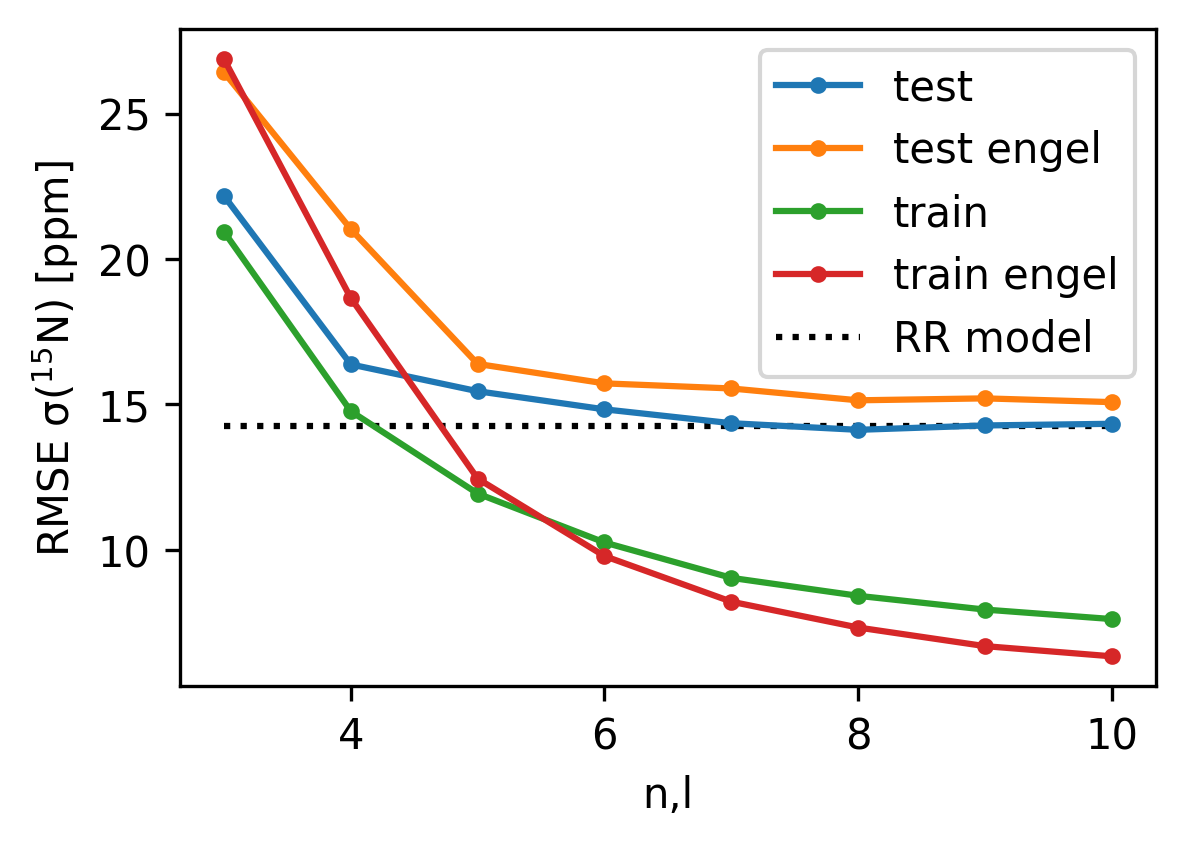

In [77]:
grid = [*range(3,11)]
plt.figure(figsize=(4.2,2.9),dpi=300)
plt.plot(grid,myerrors["7"]["rmse_test"],label="test ",marker="o",markersize=3)
plt.plot(grid,engelerrors["7"]["rmse_test"],label="test engel",marker="o",markersize=3)
plt.plot(grid,myerrors["7"]["rmse_train"],label="train",marker="o",markersize=3)
plt.plot(grid,engelerrors["7"]["rmse_train"],label="train engel",marker="o",markersize=3)
plt.hlines(14.26,3,10,color="black",linestyle="dotted",label="RR model")
plt.legend()
plt.xlabel("n,l")
plt.ylabel("RMSE σ($^{15}$N) [ppm]")
plt.savefig("n_l_curve_N.png",dpi=300,bbox_inches='tight')

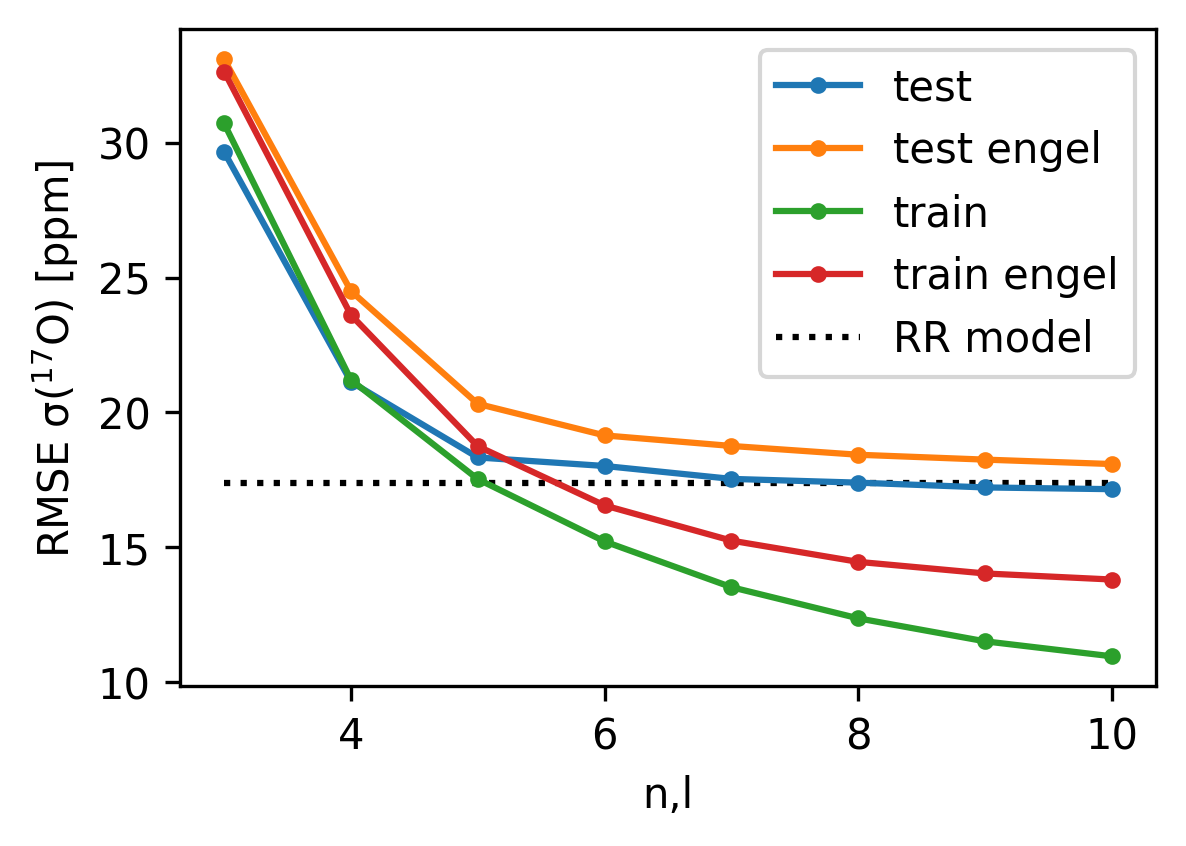

In [78]:
grid = [*range(3,11)]
plt.figure(figsize=(4.2,2.9),dpi=300)
plt.plot(grid,myerrors["8"]["rmse_test"],label="test",marker="o",markersize=3)
plt.plot(grid,engelerrors["8"]["rmse_test"],label="test engel",marker="o",markersize=3)
plt.plot(grid,myerrors["8"]["rmse_train"],label="train",marker="o",markersize=3)
plt.plot(grid,engelerrors["8"]["rmse_train"],label="train engel",marker="o",markersize=3)
plt.hlines(17.39,3,10,color="black",linestyle="dotted",label="RR model")
plt.legend()
plt.xlabel("n,l")
plt.ylabel("RMSE σ($^{17}$O) [ppm]")
plt.savefig("n_l_curve_O.png",dpi=300,bbox_inches='tight')

In [ ]:
fg = open("../")

In [31]:
with open("errors_RR.json", 'w') as fileob:
        json.dump(errors, fileob) 

In [5]:
fileob = open("errors_RR.json")
new_error = json.load(fileob)
fileob.close()

In [6]:
new_error

{'1': {'rmse_test': [0.6915782542983171,
   0.607755125874915,
   0.5485715296505629],
  'rmse_train': [0.7233392715098845, 0.6164009598131424, 0.5399757760250111],
  'mae_test': [0.5327736408032219, 0.4643041651300762, 0.4181592004433973],
  'mae_train': [0.5393357382568654, 0.4626912973197685, 0.4077683680277954],
  'alphas': [0.001, 0.001, 0.001],
  'num_feats': [540, 1200, 2250]},
 '6': {'rmse_test': [6.23928534217244, 5.483121717738451, 5.014078512055624],
  'rmse_train': [7.090733030125427, 5.978734838508926, 5.217092093003375],
  'mae_test': [4.479127868034007, 3.980643533449171, 3.6102487194353112],
  'mae_train': [5.073945995439577, 4.3452200032256725, 3.816246733219648],
  'alphas': [0.001, 0.001, 0.001],
  'num_feats': [540, 1200, 2250]},
 '7': {'rmse_test': [22.172747690539435,
   16.377714229435302,
   15.45597053443386],
  'rmse_train': [20.93799078194878, 14.768609809281132, 11.937717395195548],
  'mae_test': [15.729543565575467, 11.315105449022349, 10.424052516613372],
